In [5]:
DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
MOVIE_PATH = DATA_PATH + 'control/'
GRAPH_PATH = 'C:Users/amityu/Gel_Sheet_Graph/'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.filters import gaussian
from tqdm.notebook import trange, tqdm
import pandas as pd
import preprocessing
import importlib
from skimage import filters
from multiprocessing import Pool


The first data is obtained fron imagej a tiff file which is imported with tifffile. The size of the gel should be given with reshape as above 4gb file Tifflie doesn't know its dimenstions. the gel is stored as uint32

In [16]:
import tifffile
gel2 = tifffile.imread(MOVIE_PATH + 't2.tif')
gel2= gel2.reshape((95,186,512,512))


In [17]:
np.save(MOVIE_PATH +'np/gel.npy', gel2)

Next operations to perform on gel is to normalize each frame intensity level. I choose a rectanle in the background. each frame intensity mean on this background is normalized to the background mean in a chosen frame. usually time point zero. I can also copy background from above the gel to a background bellow the gel if some artifcat exsists. This will be important in the segmentation, otherwise thresholding based on histogram can fail.



In [19]:
#reload the module
importlib.reload(preprocessing)
gel = preprocessing.normalize_to_background(gel2, 0, 20, (0, 0), (10, 10))
gel[:, 0:20, :, :] = gel[:, -20:, :, :].copy()


  0%|          | 0/95 [00:00<?, ?it/s]

In [20]:
np.save(MOVIE_PATH + 'np/gel_norm.npy', gel)

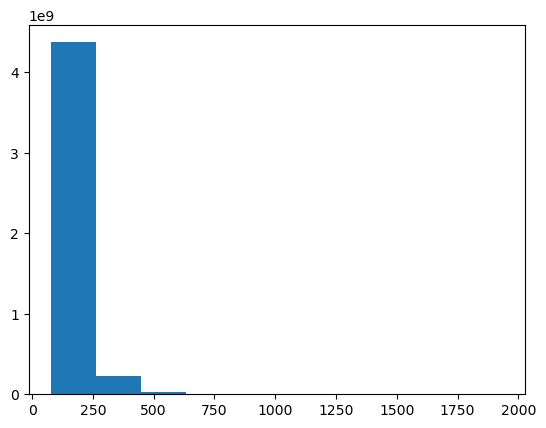

In [12]:
flat = gel.reshape(-1)
plt.hist(flat)
plt.show()

In [7]:
print ('gel min %f gel max %f' %(np.min(gel),np.max(gel)))


gel min 78.000000 gel max 1933.000000


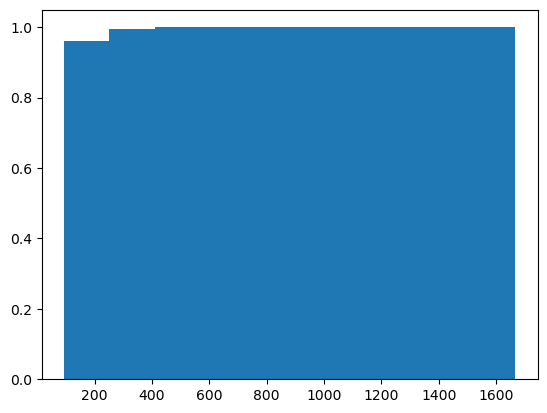

In [14]:
flat = gel[65].reshape(-1)[1:-1:10]
n, bins, patches = plt.hist(flat,cumulative=True, density=True)
plt.show()

In [15]:
min_intensity = bins[1]
max_intensity = 10000

threshold_gel = gaussian(gel[65],3)
threshold_gel[threshold_gel<min_intensity] =0
threshold_gel[threshold_gel>max_intensity] = 0
threshold_gel[np.bitwise_and(threshold_gel>= min_intensity , threshold_gel<= max_intensity)] =1

# np.save(DATA_PATH + 'tmp/t_gel.npy', threshold_gel)



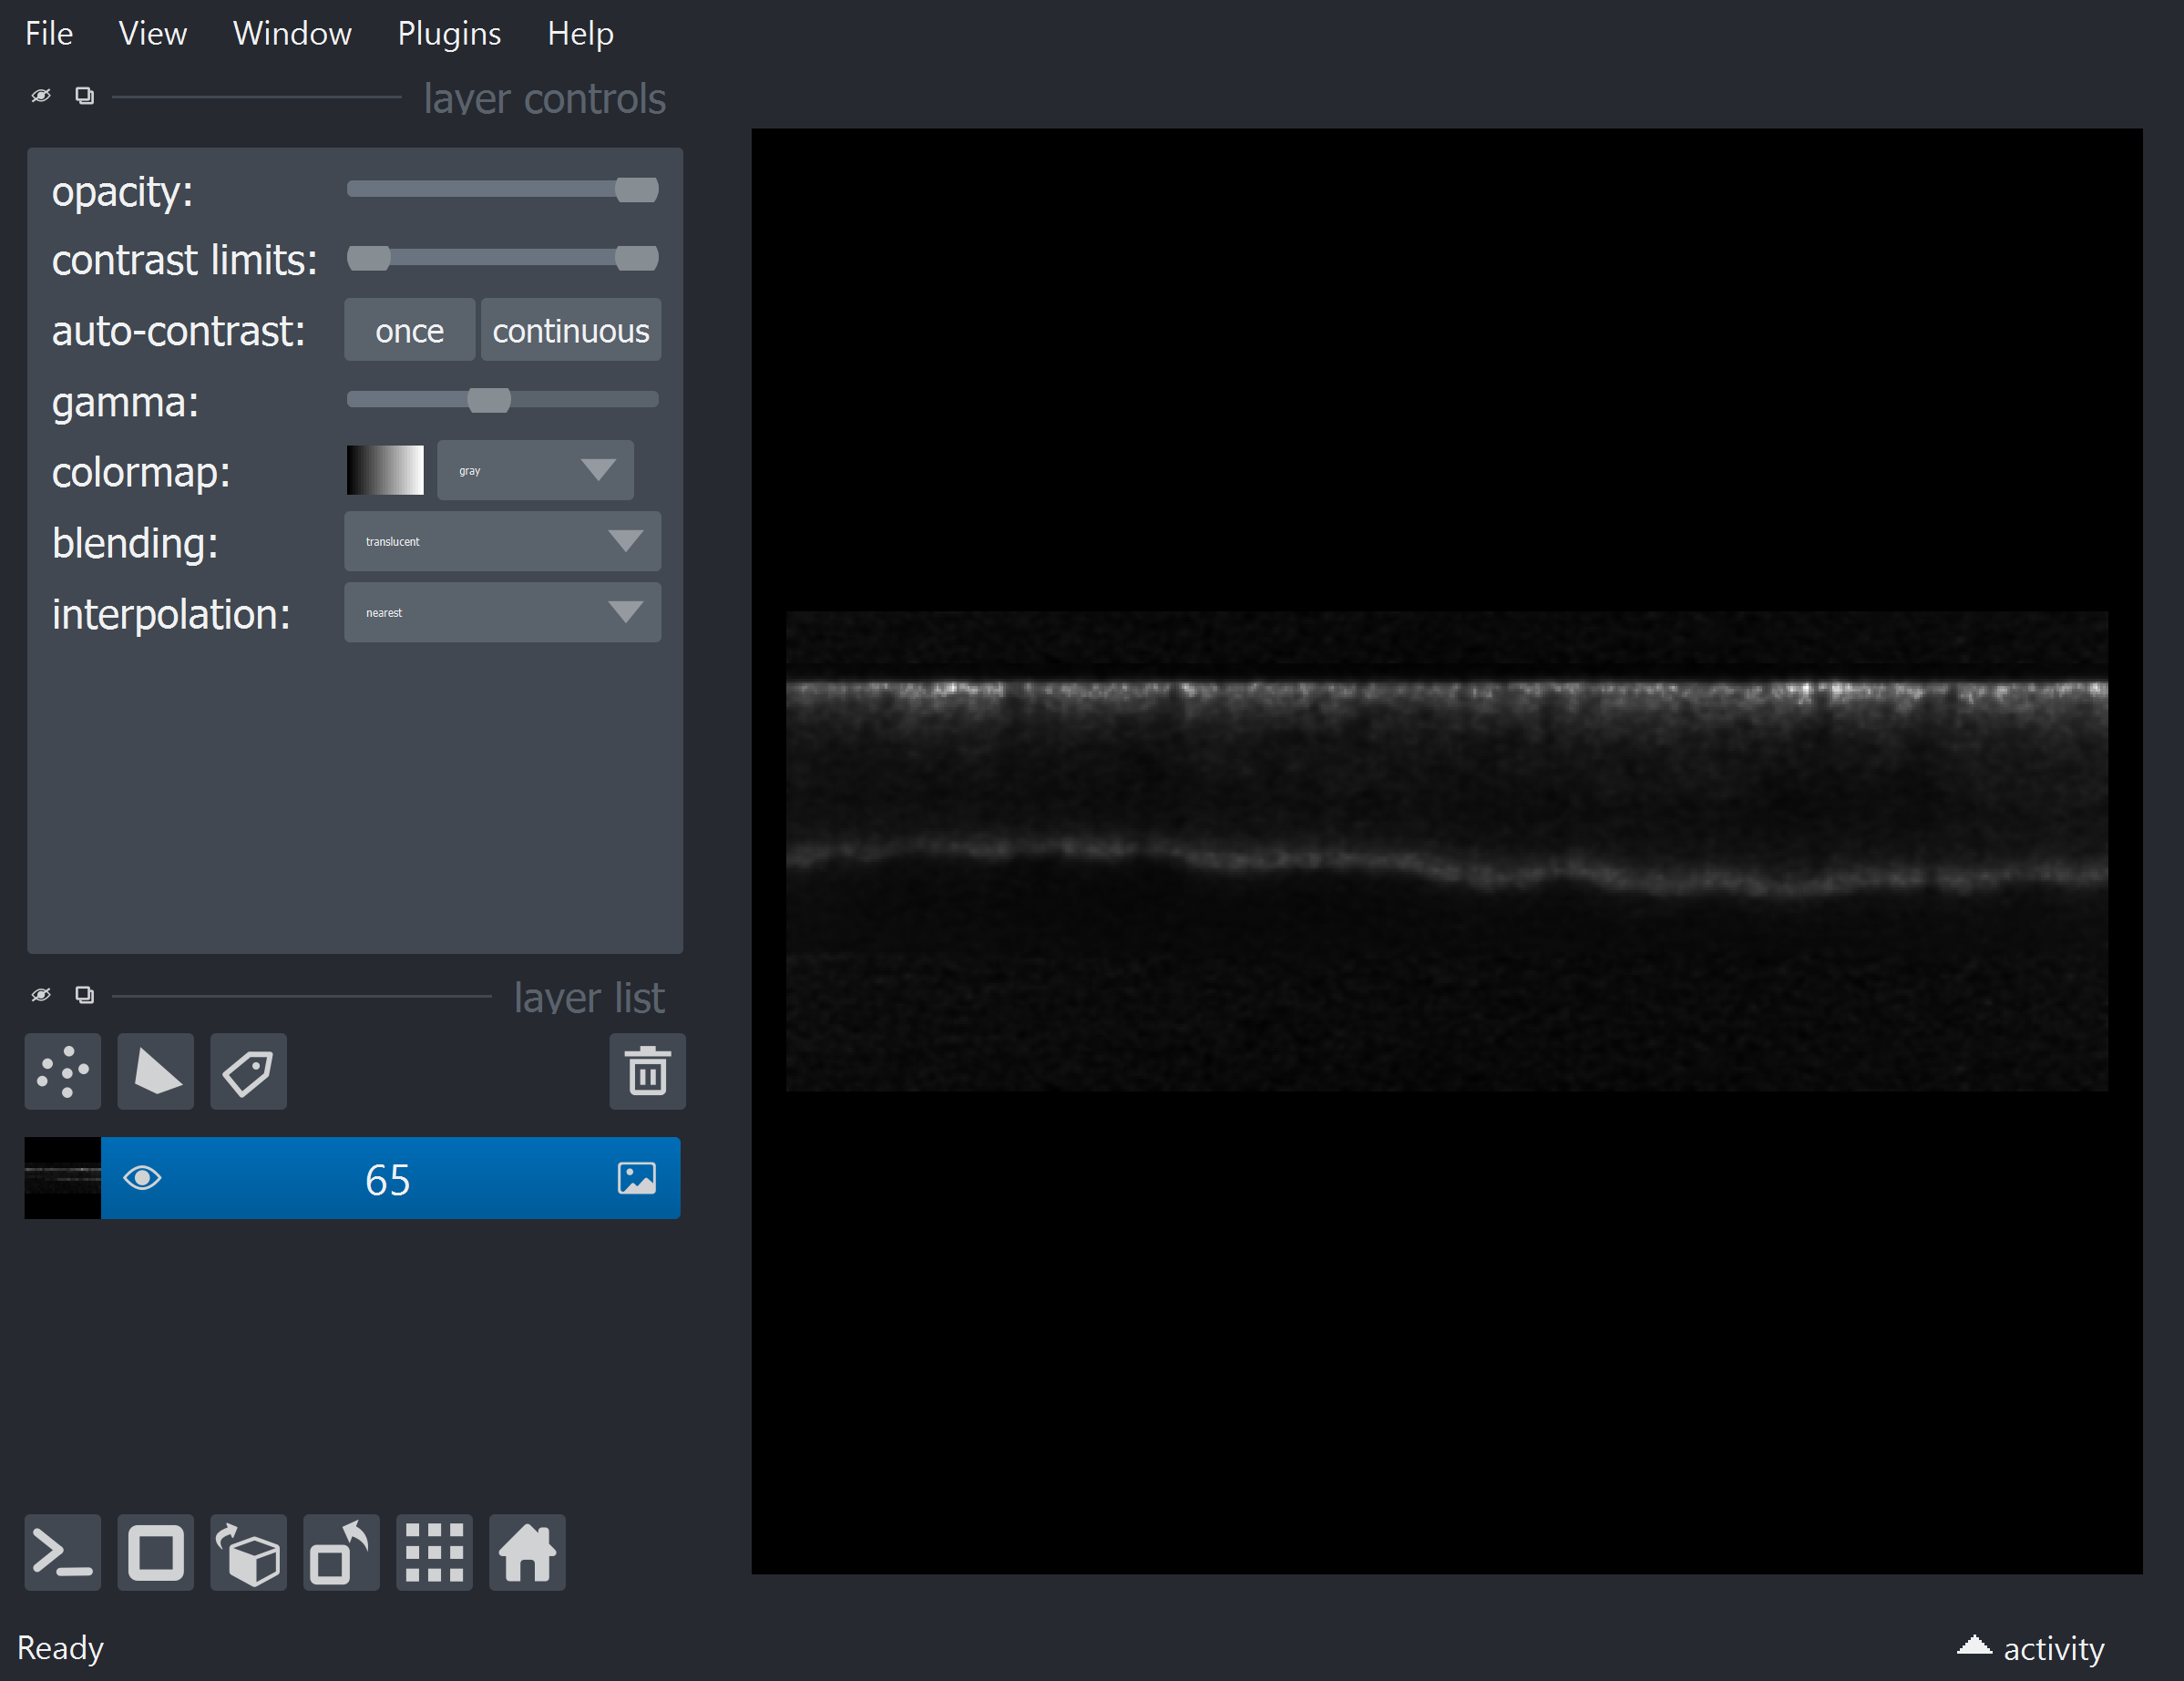

In [16]:
import napari
viewer = napari.Viewer()
image = gel[65,:,:,256]
viewer.add_image(image, name='65')
napari.utils.nbscreenshot(viewer)

In [17]:
t = 30
viewer.add_image(gel[t,:,:,256], name = 'gel %d'%t )
viewer.add_image(mask[t,:,:,256], name = 'mask %d'%t )


NameError: name 'mask' is not defined

In [19]:
''' each line across z is thresholded and segmented separately with LI threshold method based on entropy minimization'''


from  concurrent.futures import ThreadPoolExecutor
gradient_table = np.zeros((len(gel), gel.shape[2]))
height_table = np.zeros((len(gel), gel.shape[2]))
height_deviation = np.zeros((len(gel), gel.shape[2]))

def x(t):
    print('proces %d starts'%t)
    tp_mask = np.zeros(gel[t][0].shape)

    max_intensity = 10000

    gel_time_point = gel[t]
    for i in range(gel_time_point.shape[1]):
        for j in range(gel_time_point.shape[2]):
            z_line = gel_time_point[:,i,j]
            min_intensity = filters.threshold_li(z_line)

            z_line[z_line < min_intensity] =0
            z_line[z_line>max_intensity] = 0
            z_line[np.bitwise_and(z_line>= min_intensity , z_line<= max_intensity)] =1
            tp_mask[i,j] = z_line
    print('proces %d ends'%t)

    return t,tp_mask


Multi tasking on cpu heavy tasks should be done in python with multi processing instead of multi tasking for speed reasons. It can be even slower to multithread instead of one thread. however this is much better done on linux rather than on windows


In [ ]:
mask_list = []
order = []
with Pool(processes=10) as pool:

    results = pool.map(x, range(5,len(gel),20))

for result in results:
    order.append(result[0])
    mask_list.append(result[1].astype(bool).reshape(-1))

df = pd.DataFrame(np.array(mask_list))
#don't add index to the dataframe

df = pd.concat([pd.DataFrame(order, columns=['order']), df], axis=1, sort=False, ignore_index=True )

df = df.sort_values('order')
mask = df.to_numpy(MOVIE_PATH + 'tmp/mask.npy', order='C').reshape((len(gel), gel.shape[1], gel.shape[2], gel.shape[3]))
#save the mask
np.save(MOVIE_PATH + 'tmp/mask3.npy', mask)



In [ ]:
for t in trange(len(gel)):
    x(t)

np.save(MOVIE_PATH + 'tmp/gradient_table.npy', gradient_table)
np.save(MOVIE_PATH + 'tmp/height_table.npy', height_table)
np.save(MOVIE_PATH + 'tmp/height_deviation.npy', height_deviation)
np.save(MOVIE_PATH + 'tmp/mask.npy', gel)



In [19]:
gradient_table = np.load(MOVIE_PATH + 'tmp/gradient_table.npy')
height_table = np.load(MOVIE_PATH + 'tmp/height_table.npy')
height_deviation = np.load(MOVIE_PATH + 'tmp/height_deviation.npy')

The next graphs are very good to see that segmentation really works but since they work only on one plane at each time frame and not all data they are not what we are looking for


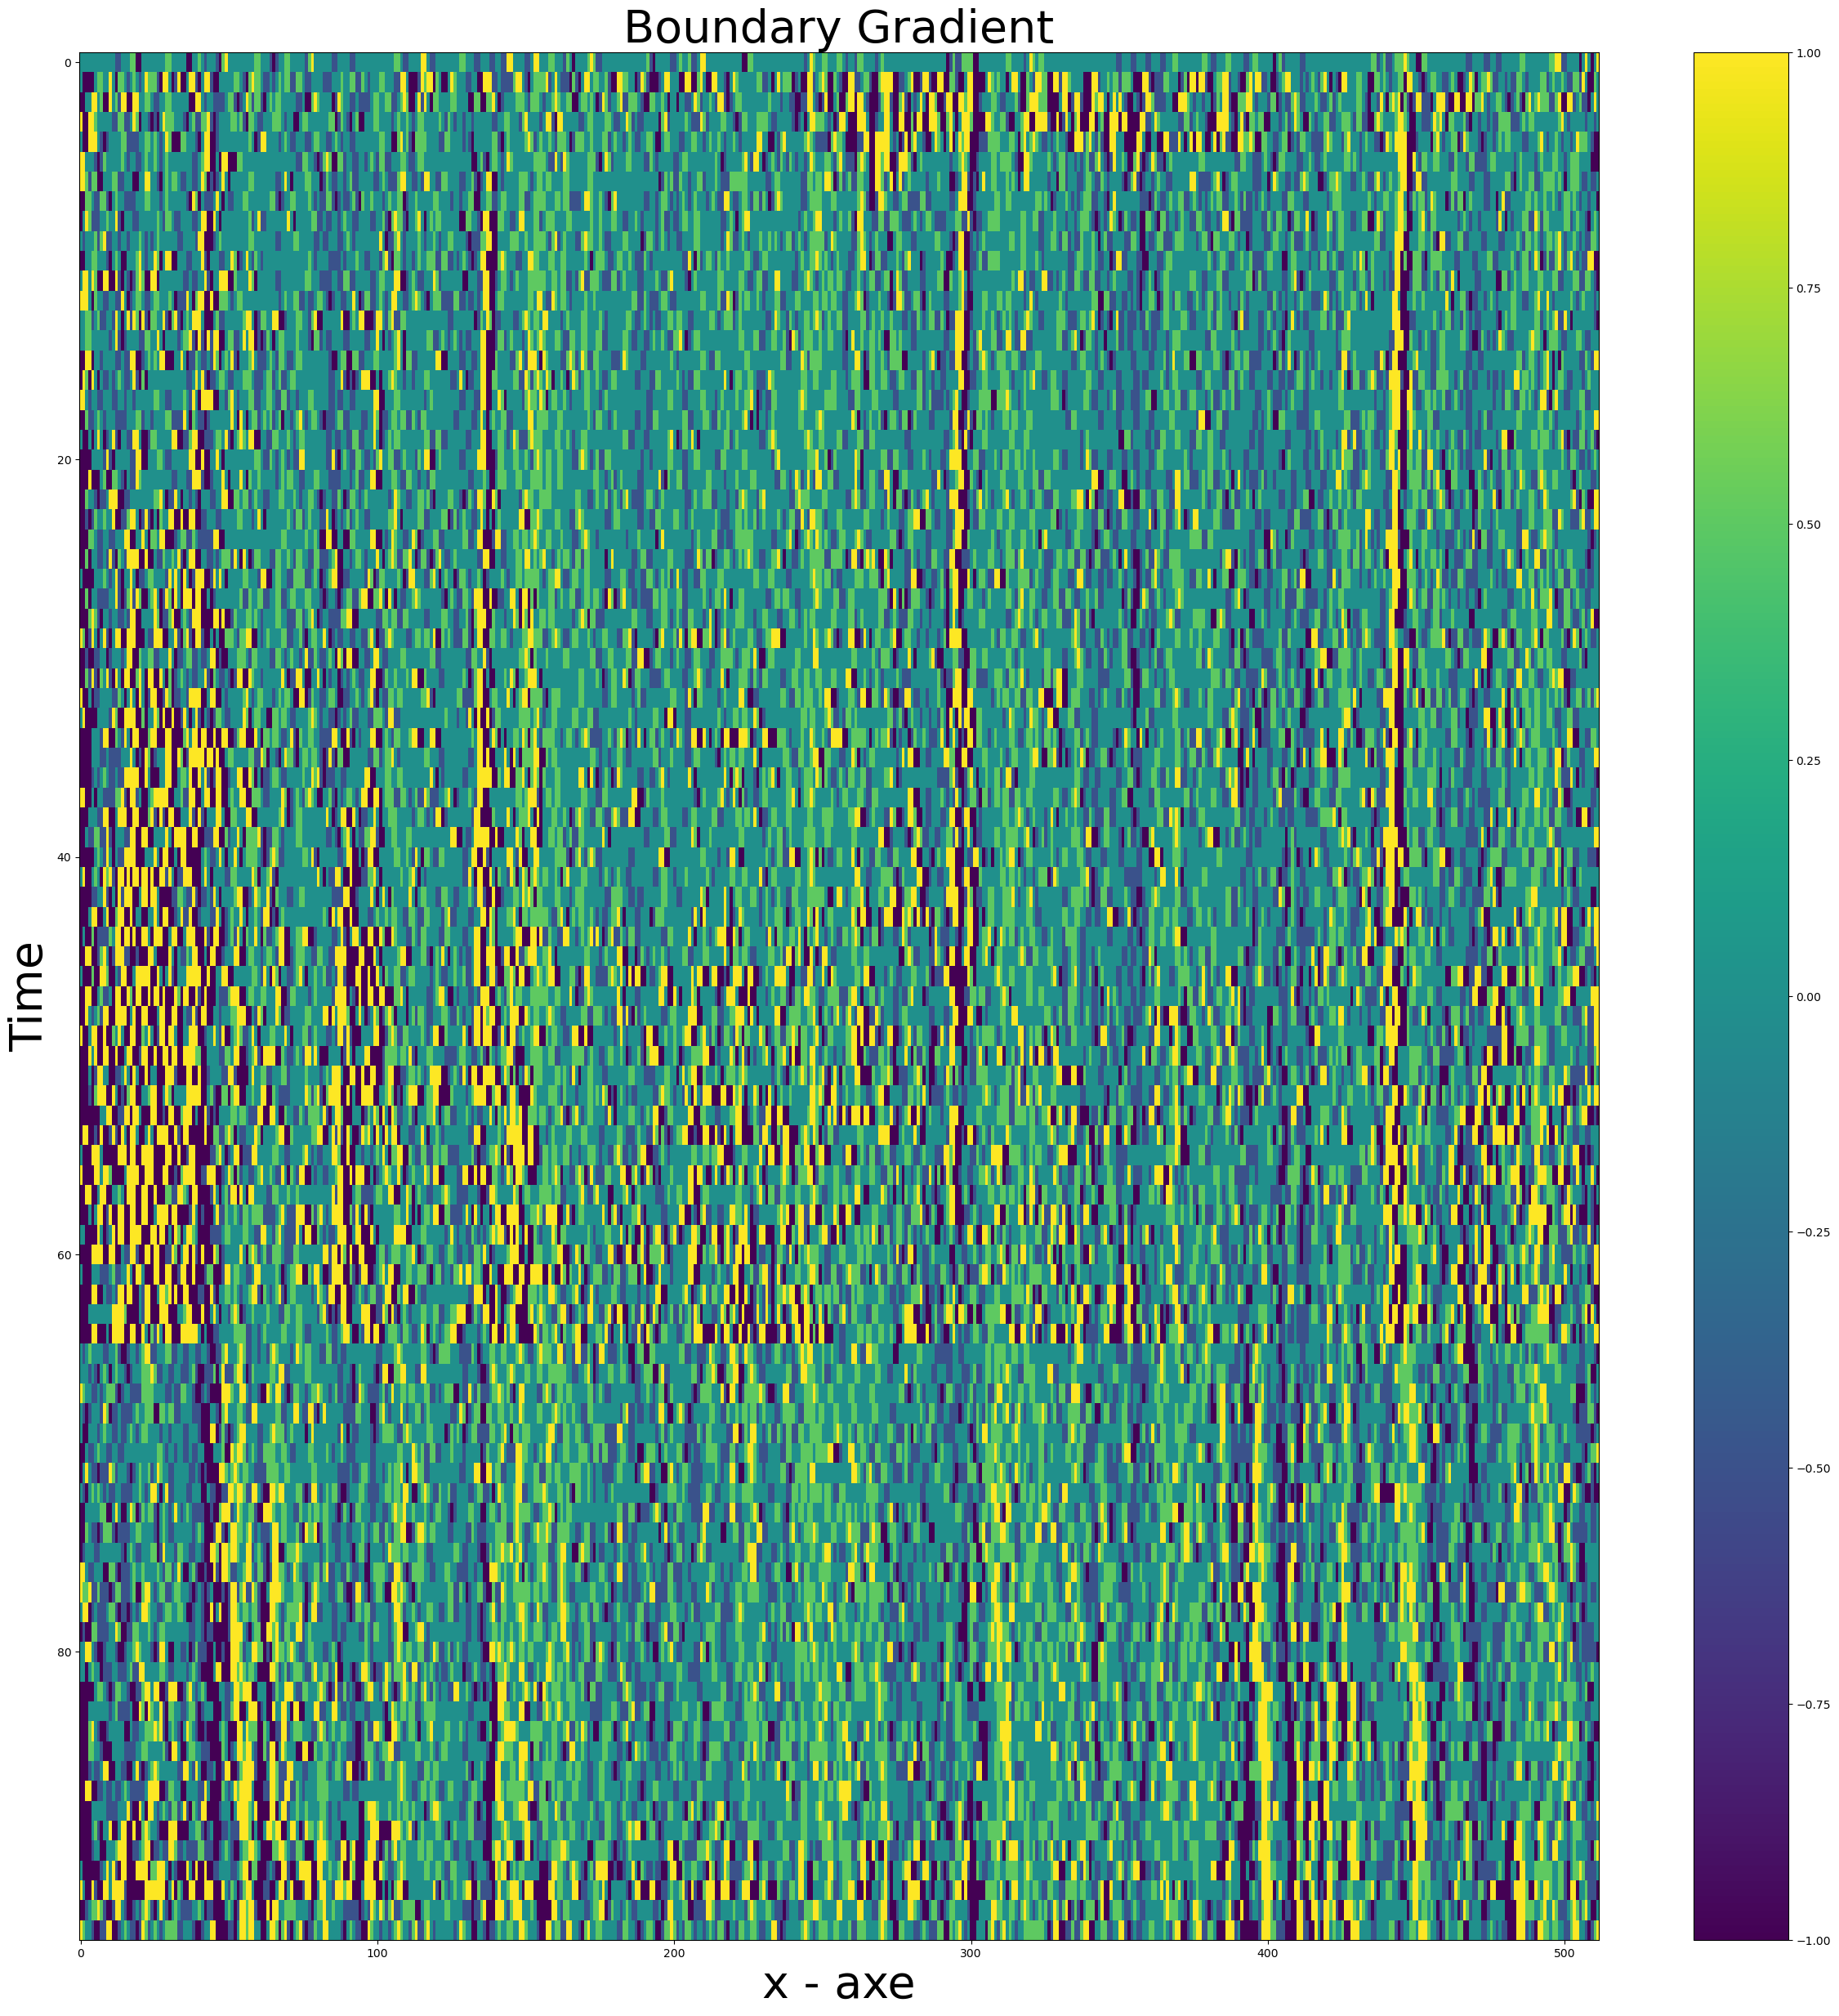

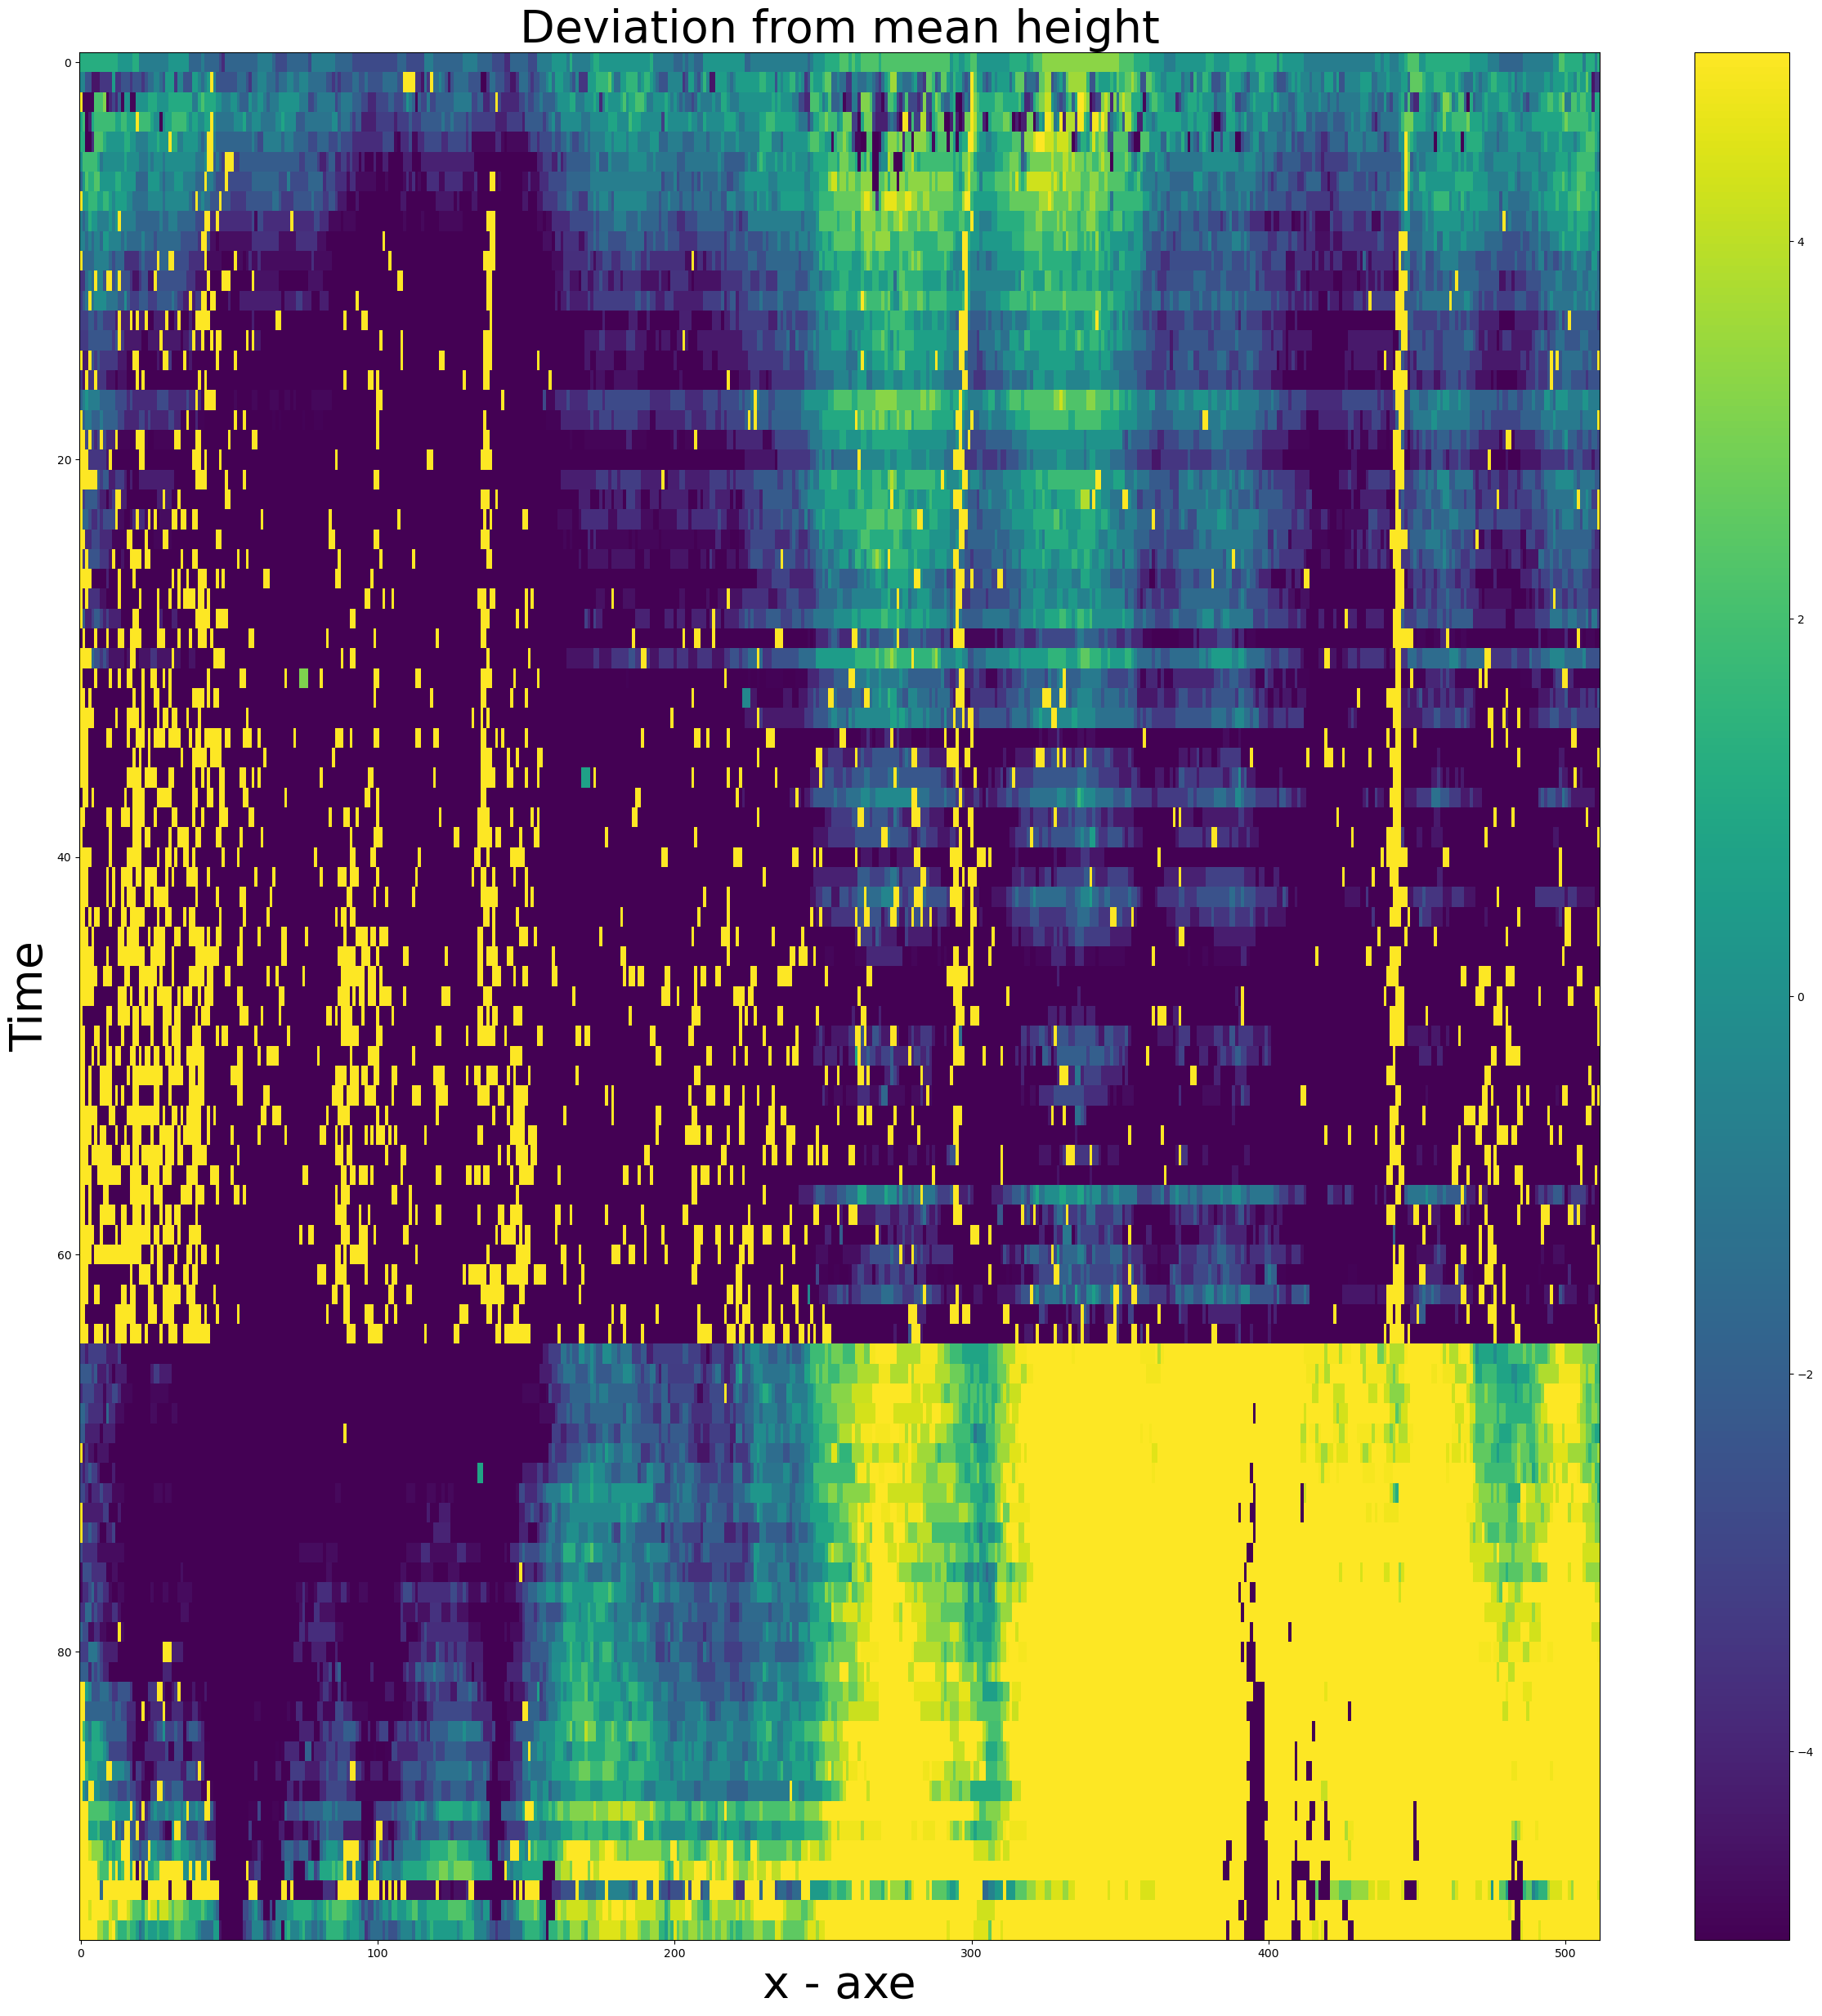

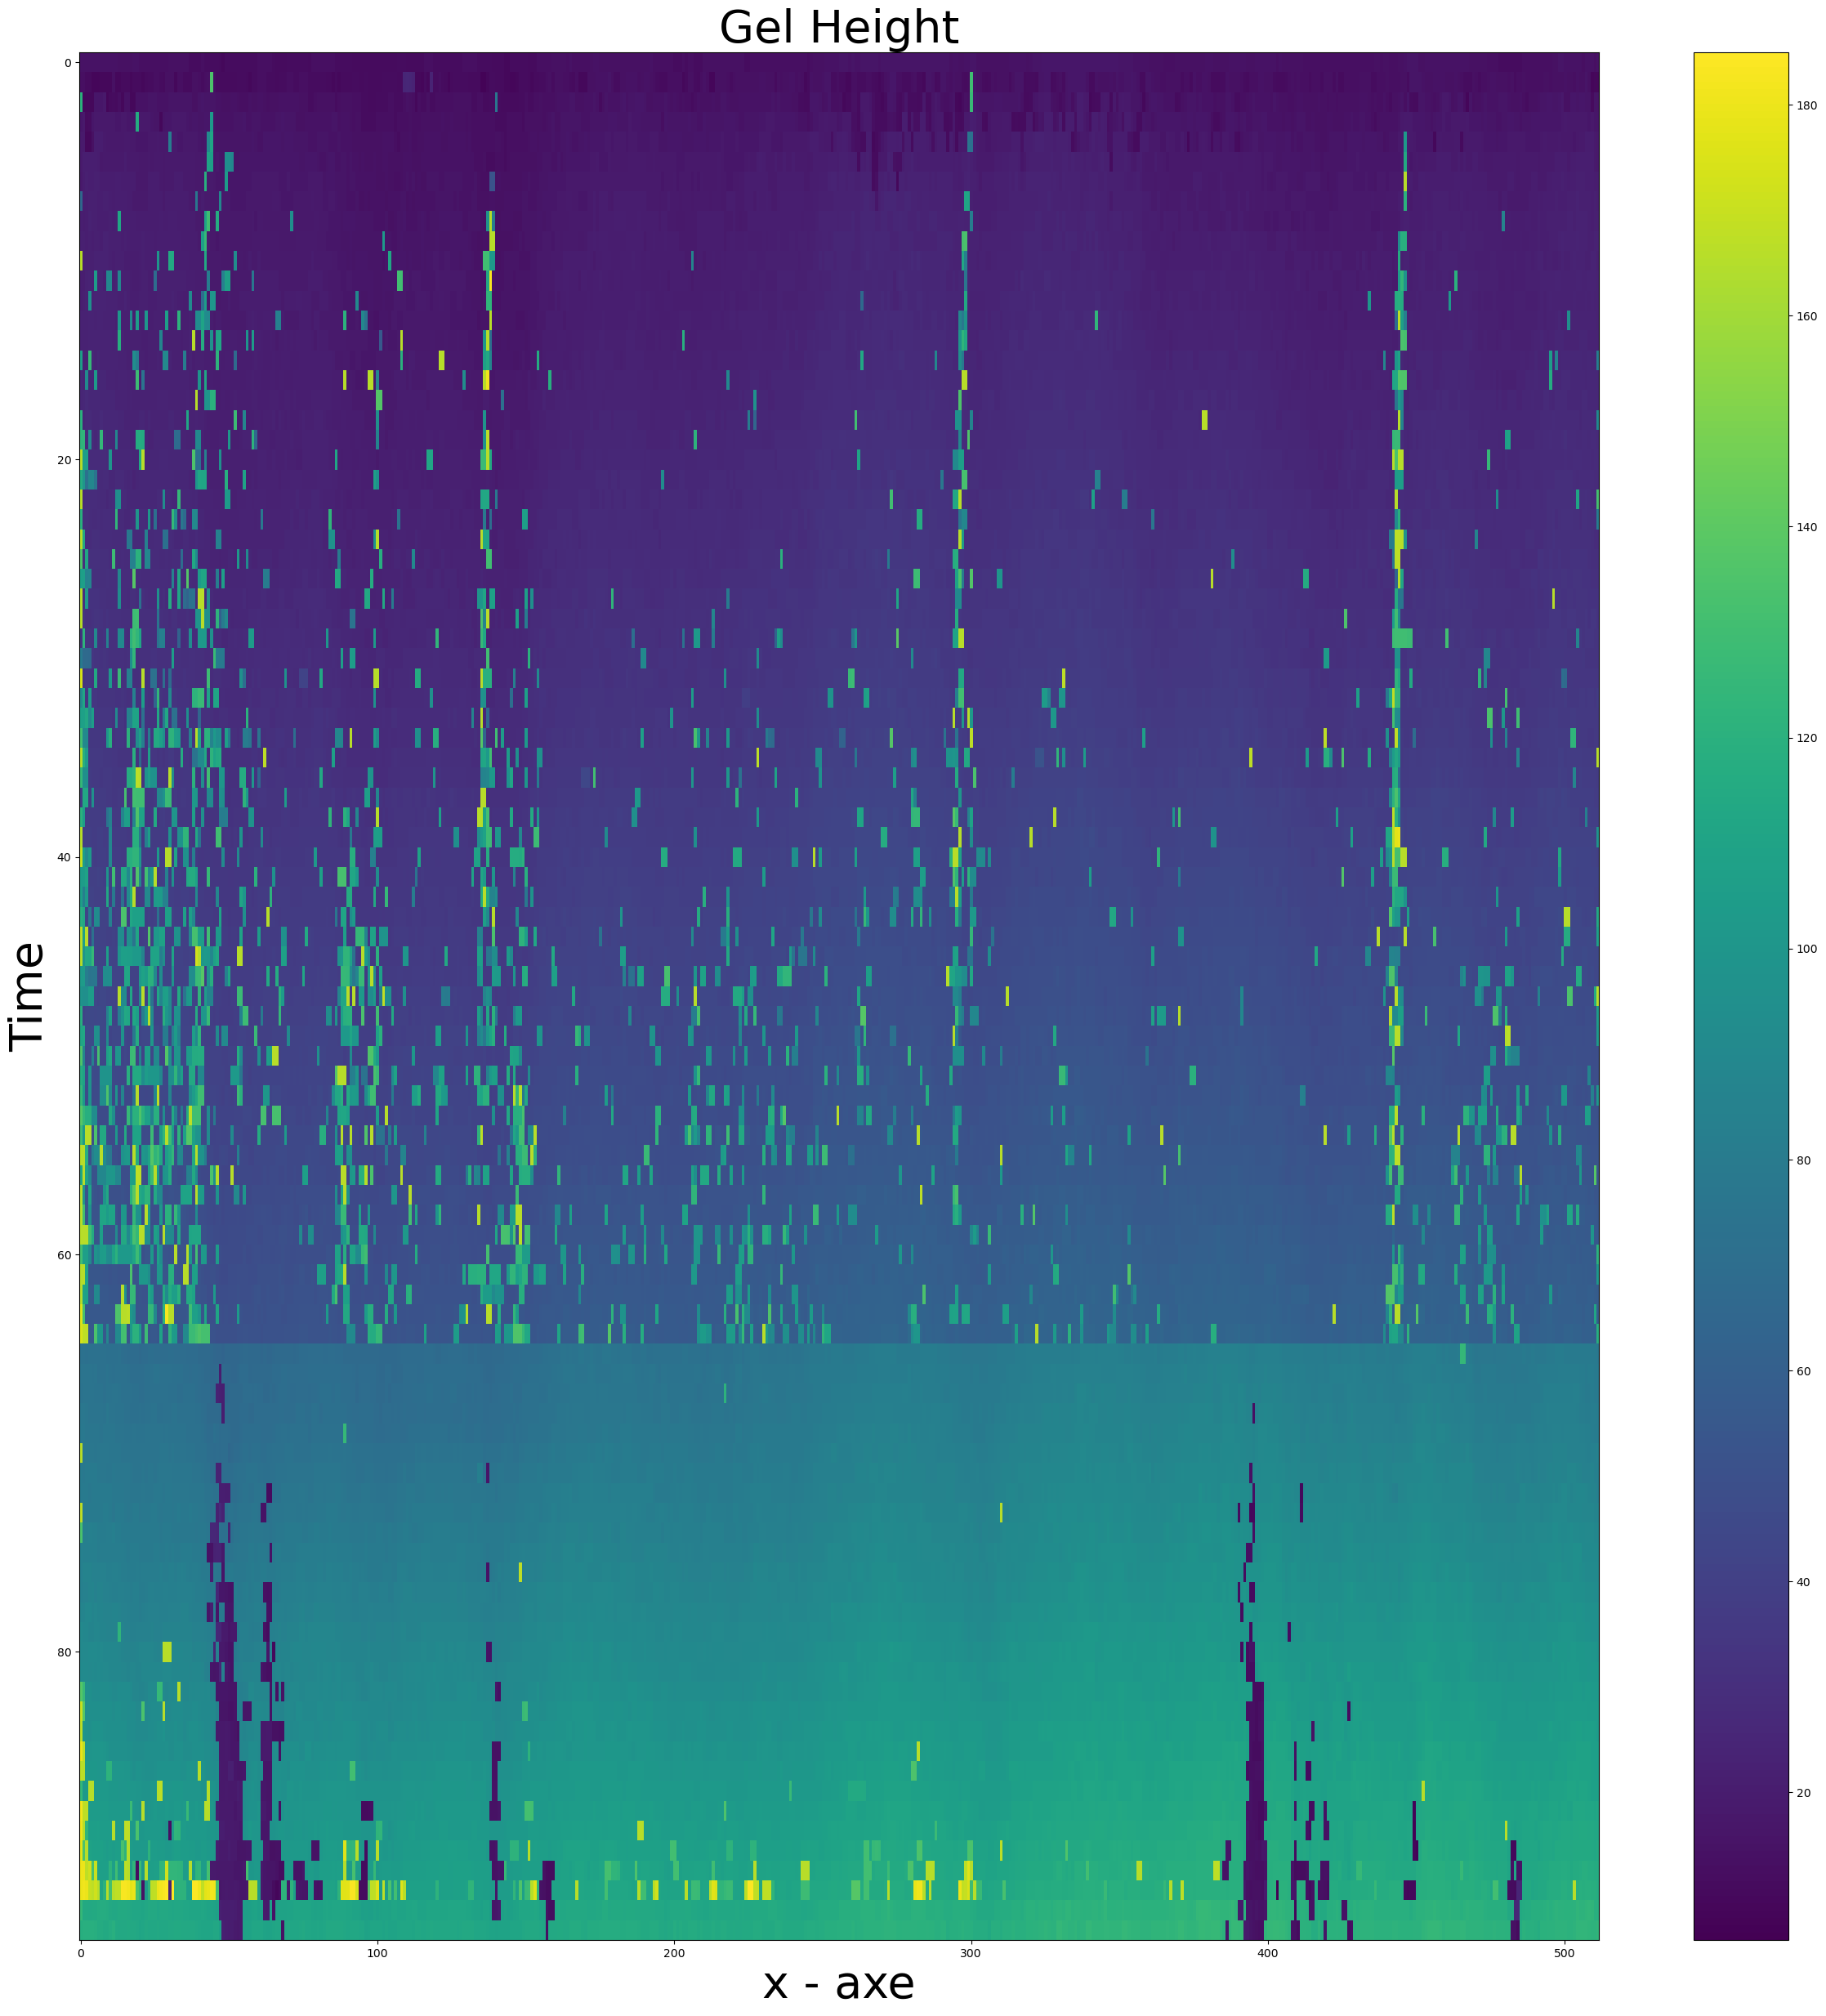

  0%|          | 0/95 [00:00<?, ?it/s]

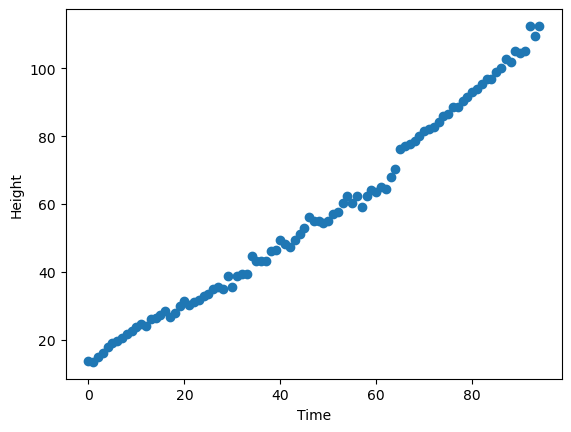

In [20]:
#gradient_table = gradient_table[range(len(gradient_table)-1,0,-1)]
plt.figure(figsize=(30, 30))
plt.imshow(gradient_table, vmin=-1, vmax=1, aspect='auto')
plt.xlabel('x - axe', fontsize=40)
plt.ylabel('Time', fontsize=40)
plt.title('Boundary Gradient', fontsize=40)
plt.colorbar()
plt.show()

plt.figure(figsize=(30, 30))
plt.imshow(height_deviation, vmin=-5, vmax=5, aspect='auto')
plt.xlabel('x - axe', fontsize=40)
plt.ylabel('Time', fontsize=40)
plt.title('Deviation from mean height', fontsize=40)
plt.colorbar()
plt.show()

plt.figure(figsize=(30, 30))
plt.imshow(height_table, aspect='auto')
plt.xlabel('x - axe', fontsize=40)
plt.ylabel('Time', fontsize=40)
plt.title('Gel Height', fontsize=40)
plt.colorbar()
plt.show()

mean_height = np.zeros(len(height_table))
for t in trange(len(height_table)):
    mean_height[t] = np.nanmean(height_table[t])
plt.scatter(range(len(mean_height)), mean_height)
plt.xlabel('Time')
plt.ylabel('Height')
plt.show()

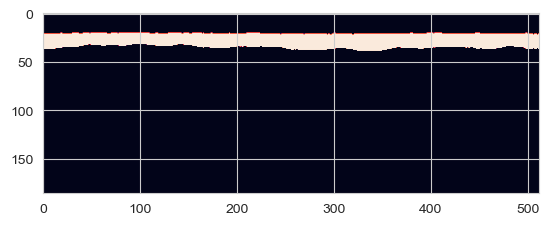

In [3]:
'''applying active contour to mask for each time point'''
" impurt active contour from skimage"
from skimage.segmentation import active_contour
#load mask
mask = np.load(MOVIE_PATH + 'np/mask.npy')
plt.imshow(mask[0,:,:,256])
plt.show()

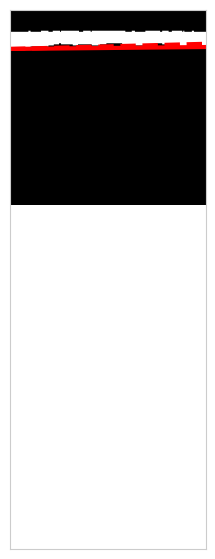

In [12]:
'''active contour'''
" define snake"
s = np.linspace(0, mask.shape[2], 1000)
#get y cordinate of first true value in mask at x = 0
y1 = np.where(mask[0,:,:,256][:,0] == True)[0][0]
#get y cordinate of first true value in mask at x = 511
y2 = np.where(mask[0,:,:,256][:,511] == True)[0][0]
#get y cordinate of last     true value in mask at x = 0
h1 = np.where(mask[0,:,:,256][:,0] == True)[0][-1]
#get y cordinate of last     true value in mask at x = 511
h2 = np.where(mask[0,:,:,256][:,511] == True)[0][-1]-5


#interpolate y cordinates
y = np.interp(s, [0, mask.shape[1]], [y1, y2])
#initialize snake
init = np.array([s, y]).T
#attacg snake to edge of image  and minimize energy
#snake = active_contour(mask[0,:,:,256], init, alpha=0.015, beta=10, gamma=0.001, boundary_condition='free')
# now make another segmentation with h1 and h2
y = np.interp(s, [0, mask.shape[1]], [h1, h2])
#initialize snake
init = np.array([s, y]).T
#attacg snake to edge of image  and minimize energy

h_snake = active_contour(mask[0,:,:,256], init, boundary_condition='free',alpha=1500, beta=2000, gamma=0.001, w_edge=0, w_line =1)

# #show both snakes on image
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.imshow(mask[0,:,:,256], cmap=plt.cm.gray)

ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
#ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.plot(h_snake[:, 0], h_snake[:, 1], '-r', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, mask.shape[1], mask.shape[2], 0])
plt.show()



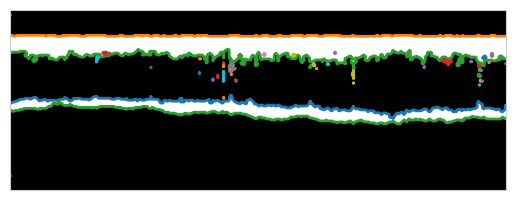

In [15]:
#import find_contours from skimage

from skimage.measure import find_contours
#find contours of mask[0,:,:,256]
#show the contours
#save contours to variable contours

fig, ax = plt.subplots()
ax.imshow(mask[70,:,:,256], interpolation='nearest', cmap=plt.cm.gray)
for n, contour in enumerate(find_contours(mask[70,:,:,256], 0.8)):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()


In [7]:
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy')

C:\Users\amityu\AppData\Local\Temp\ipykernel_2040\283846920.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])


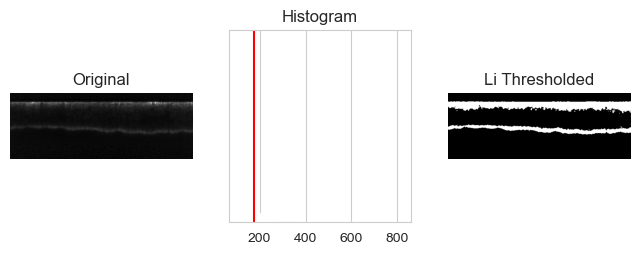

In [9]:
image = gel[70,:,:,256]
from skimage.filters.thresholding import threshold_otsu, threshold_li, threshold_yen, threshold_isodata, threshold_minimum, threshold_triangle
thresh = threshold_li(image)
binary = image > thresh
fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')
ax[1].set_yticks([])
ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Li Thresholded')
ax[2].axis('off')
plt.show()
